In [9]:
using LinearAlgebra
using SparseArrays
using GaussQuadrature
using Plots

In [10]:
function exemplo1()
    α = 1.0
    β = 1.0
    f(x) = -2.0 * α + β * x *(x-1.0)
    u(x) = x * (x - 1.0)
    return α, β, f, u
end
function Exemplo2()
    α = 1.0 
    β = 1.0
    f(x) = (α*π^2 + β) *sin(π*x)
    u(x) = sin(π*x)
    return α, β, f, u
end
function Exemplo3()
    α = 1.0 
    β = 0.0
    f(x) = 8.0
    u(x) = -4.0 * x * (x - 1.0)
    return α, β, f, u
end
function Exemplo4()
    α = 1.0 
    β = 1.0
    f(x) = x
    u(x) = x + (exp(-x) - exp(x)) / (exp(1) - exp(-1))
    return α, β, f, u
end

"Retorna os valores de `α`, `β`, `f` e `u` de acordo com o exemplo escolhido."
function dados_de_entrada(exemplo)
    if exemplo == 1
        return exemplo1()
    elseif exemplo == 2
        return Exemplo2()
    elseif exemplo == 3
        return Exemplo3()
    elseif exemplo == 4
        return Exemplo4()
    else
        error("Exemplo inválido. Escolha 1, 2, 3 ou 4.")
    end
end

dados_de_entrada

In [11]:
function X(x::Float64, h::Float64, i::Int)
    previous_x = (i - 1) * h
    return previous_x + h*(x + 1)/2
end

function fi_1(psi::Float64)
    return (1 - psi)/2
end

function fi_2(psi::Float64)
    return (1 + psi)/2
end

function d_fi(psi, a)
    if a == 1
        return -1.0 / 2.0
    elseif a == 2
        return 1.0 / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end



d_fi (generic function with 1 method)

## Cálculo da matriz local $K^e$ - via quadratura gaussia

In [12]:

function make_Ke(alfa::Float64, beta::Float64, h::Float64, npg::Int=2)
    P, W = legendre(npg)
    K = zeros(2, 2)
    c1 = 2*alfa/h
    c2 = beta*h/2

    for a in 1:2
        for b in 1:2
            for j in 1:npg
                K[a, b] += W[j] * (d_fi(P[j], a) * d_fi(P[j], b) * c1 + fi_1(P[j]) * fi_2(P[j]) * c2)
            end
        end
    end

    return K
end

make_Ke (generic function with 2 methods)

## Montagem da matriz global K a partir da matriz local $K^e$

In [13]:
function make_K(alfa, beta, m)
    h = 1.0 / (m+1)
    K = spzeros(m, m)
    Ke = make_Ke(alfa, beta, h)

    for e in 2:m
        K[e-1:e,e-1:e] += Ke
    end

    K[1,1] += Ke[2,2]
    K[m,m] += Ke[1,1]

    return K
end

make_K (generic function with 1 method)

## Cálculo do vetor local $F^e$ - via quadratura gaussiana

In [14]:
function make_Fe(f::Function, h::Float64, e::Int, npg::Int=5)
    Fe = zeros(2)     
    P, W = legendre(npg)
    for a = 1:2
        for j = 1:npg
            x = X(P[j], h, e)
            Fe[a] += W[j] * f(x) * fi_1(P[j]) * h/2
        end
    end
    
    return Fe
end

make_Fe (generic function with 2 methods)

## Montagem do vetor global F a partir do vetor local $F^e$


In [15]:
function make_F(f::Function, m::Int)
    h = 1.0 / (m + 1)
    F = zeros(m)
    
    for e = 2:m
        F[e-1:e] += make_Fe(f,h,e) 
    end
    
    F[1] += make_Fe(f,h,1)[2]   
    F[m] += make_Fe(f,h,m+1)[1] 

    return F
end

make_F (generic function with 1 method)

## Comparando a solução aproximada com a solução exata


"Matriz K:"

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.0  -4.0    ⋅ 
 -4.0   8.0  -4.0
   ⋅   -4.0   8.0

"Vetor F:"

3-element Vector{Float64}:
 1.9999999999999991
 1.9999999999999991
 1.9999999999999991

"Solução aproximada U:"

3-element Vector{Float64}:
 0.7499999999999994
 0.9999999999999993
 0.7499999999999994

"Solução exata nos nós internos:"

3-element Vector{Float64}:
 0.75
 1.0
 0.75

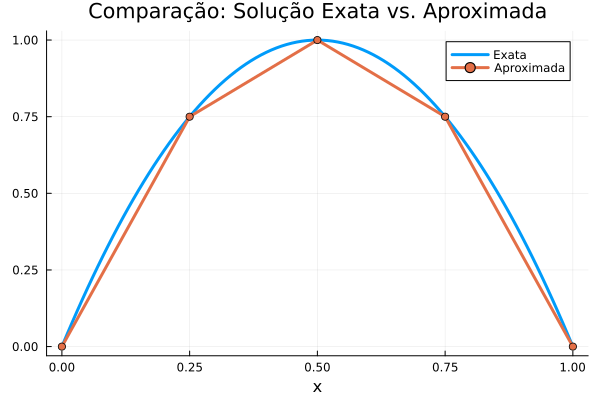

In [16]:
exemplo = 3
alfa, beta, f, u = dados_de_entrada(exemplo)

# Define o número de nós internos na malha
N = 3

# Constrói a matriz K e o vetor F
K = make_K(alfa, beta, N)
F = make_F(f, N)

# Exibe a matriz K (sistema linear) e o vetor F (vetor força)
display("Matriz K:")
display(K)
display("Vetor F:")
display(F)

# Resolve o sistema linear K * c = F para obter os coeficientes solução aproximada u_h(x)
c = K \ F
display("Solução aproximada U:")
display(c)

# Exibe a solução exata nos nos internos da malha
display("Solução exata nos nós internos:")
h = 1.0 / (N + 1)  # Tamanho do passo
display(u.(h:h:1-h))

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = LinRange(0, 1, N+2)

# Gera o gráfico comparando a solução aproximada com a solução exata
plt = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt, malha, [0; c; 0], label="Aproximada", lw=3, linestyle=:solid, markershape=:circle) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt)